In [ ]:
#import data 
import numpy as np
data=np.load("/content/drive/MyDrive/PGPAIML/Computer Vision/Week 7 project/Part 1- Train data - images.npy",allow_pickle=True)

In [ ]:
#Extracting images and mask
import cv2
image_size=224
masks = np.zeros((int(data.shape[0]), image_size, image_size))
X_train = np.zeros((int(data.shape[0]), image_size, image_size, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    #img = (img / 255.).astype(np.float32)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index]= np.array(img, dtype=np.float32)
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * image_size)
        x2 = int(i["points"][1]['x'] * image_size)
        y1 = int(i["points"][0]['y'] * image_size)
        y2 = int(i["points"][1]['y'] * image_size)
        masks[index][y1:y2, x1:x2] =1

In [ ]:
#Installing required version of libraries
!pip install git+https://github.com/qubvel/segmentation_models

!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
!pip install -U segmentation-models==0.2.1

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8sm7r_mg
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8sm7r_mg
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=b90f5a184717bbcc8e1f9ddfa341466db85f4eccd4f21c6262c72af97e1d0de1
  Stored in directory: /tmp/pip-ephem-wheel-cache-zrjywidq/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 37.0MB/s 
     |████████████████████████████████| 450kB 35.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=e20feab45496847f096eaa760c05523c74f338bd1d4206d2f64b5086f9ac634e
  Stored in directory: /root/.cache/p

In [ ]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json
import segmentation_models as sm

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

In [ ]:
#Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X_train, masks, test_size=0.2)
BACKBONE = 'mobilenet'
#preprocessing data and backbone is mobilenet
preprocess_input = get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))

In [ ]:
x_train.shape

(327, 224, 224, 3)

* Unet is applied with Mobilenet backbone
* Input shape is (224,224,3)
* Imagenet weights are used

In [ ]:
#Building last layer of the model
from keras.layers import Reshape
from keras import layers
N = x_train.shape[-1]

base_model = Unet(backbone_name=BACKBONE, encoder_weights='imagenet')

inp = Input(shape=(224, 224, N))

l1 = Conv2D(3, (1, 1))(inp)

out = base_model(l1)

x1 = Conv2D(10, kernel_size =3,padding = "same", activation="relu")(out)
x1 =layers.BatchNormalization()(x1)

x2= Conv2D(10, kernel_size=3,padding = "same", activation="relu")(x1)
x2 =layers.BatchNormalization()(x2)

x3 = Conv2D(10, kernel_size=3,padding = "same", activation="relu")(x2)
x3 =layers.BatchNormalization()(x3)

x4 = Conv2D(3,kernel_size=3,padding = "same", activation="relu")(x3)
x5 = Conv2D(1, kernel_size=1, activation="sigmoid")(x4)

x_out = Reshape((224,224))(x5)

model = Model(inp, x_out, name=base_model.name)
model.summary()

/usr/local/lib/python3.7/dist-packages/segmentation_models/backbones/mobilenet.py:191: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Model: "u-mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 3)       12        
_________________________________________________________________
u-mobilenet (Model)          multiple                  8336337   
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 10)      100       
_________________________________________________________________
batch_normalization_10 (Batc (None, 224, 224, 10)      40        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 10)      910       
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 10)      

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import flatten,sum

In [ ]:
#creating dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1e-10
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

In [ ]:
#defining loss
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
# compile model
adam = Adam(learning_rate=0.0001)
model.compile('Adam', loss=loss, metrics=[dice_coefficient])

In [ ]:
#Defining model checkpoint, early stopping and reduce on plateau
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
early_stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduced_plat = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
# fit model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=1,    
    epochs=25,callbacks=[checkpoint,reduced_plat, early_stop],
    validation_data=(x_test, y_test),
)

Train on 327 samples, validate on 82 samples
Epoch 1/25
327/327 [==============================] - 443s 1s/step - loss: 1.3151 - dice_coefficient: 0.4341 - val_loss: 1.3202 - val_dice_coefficient: 0.4143

Epoch 00001: loss improved from inf to 1.31513, saving model to model-1.32.h5
Epoch 2/25
327/327 [==============================] - 449s 1s/step - loss: 0.9751 - dice_coefficient: 0.5401 - val_loss: 1.2972 - val_dice_coefficient: 0.5496

Epoch 00002: loss improved from 1.31513 to 0.97510, saving model to model-0.98.h5
Epoch 3/25
327/327 [==============================] - 455s 1s/step - loss: 0.9100 - dice_coefficient: 0.5679 - val_loss: 1.0964 - val_dice_coefficient: 0.5634

Epoch 00003: loss improved from 0.97510 to 0.91005, saving model to model-0.91.h5
Epoch 4/25
327/327 [==============================] - 448s 1s/step - loss: 0.8473 - dice_coefficient: 0.5939 - val_loss: 1.0982 - val_dice_coefficient: 0.5104

Epoch 00004: loss improved from 0.91005 to 0.84731, saving model to model

In [ ]:
#Evaluating the model
model.evaluate(x_test, y_test, verbose=1)

82/82 [==============================] - 24s 299ms/step


[2.898721665870853, 0.26599693298339844]

In [ ]:
#Save weights
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/PGPAIML/Computer Vision/Week 7 project/model_mobilenet.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_test, verbose=1)

82/82 [==============================] - 24s 295ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


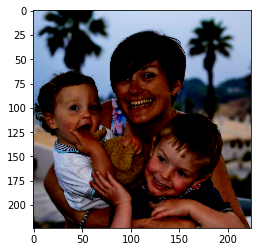

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[4])

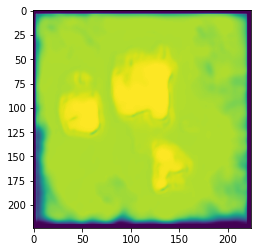

In [ ]:
plt.imshow(preds_train[4])

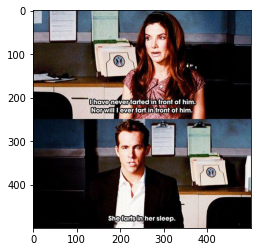

In [ ]:
from matplotlib import image
from matplotlib import pyplot
predict_image = image.imread('/content/drive/MyDrive/PGPAIML/Computer Vision/Week 7 project/Part 1Test Data - Prediction Image.jpeg')
plt.imshow(predict_image)

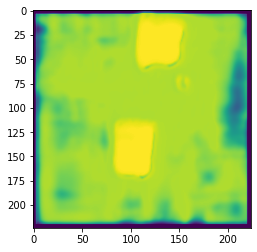

In [ ]:
predict_image = np.resize(predict_image, (1, 224, 224, 3))
predict_image.shape
pred_mask = model.predict(x=predict_image)
pred_mask = np.resize(pred_mask, (224, 224))
pyplot.imshow(pred_mask)

In [2]:
import re
string="Best wisher to all of you for your PayPal interviews"
a=re.search("al",string,re.IGNORECASE)
b=re.match("al",string,re.IGNORECASE)
c=re.findall("al",string,re.IGNORECASE)
d=re.split("al",string,re.IGNORECASE)

In [3]:
a

<re.Match object; span=(15, 17), match='al'>

In [4]:
b

In [5]:
c

['al', 'al']

In [6]:
d

['Best wisher to ', 'l of you for your PayP', ' interviews']